<a href="https://colab.research.google.com/github/HoangTechCS-AIE/SIC_EuroSAT/blob/main/vgg19_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### 1. Import the Relevent Packages

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets, models
import cv2
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
from glob import glob
from torchsummary import summary
import os
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#### 2. Prepare the Dataset

In [ ]:
class MyDataset(Dataset):

    def __init__(self, root, transform_status=True):

        self.root = root
        self.images_paths = [glob(f'{root}/{folder}/*.jpg') for folder in os.listdir(f"{root}")]

        import itertools
        self.images_paths = list(itertools.chain.from_iterable(self.images_paths))

        import random
        random.shuffle(self.images_paths)

        self.classes_names = {class_name:label for label, class_name in enumerate(os.listdir(f"{root}"))}
        self.labels = [self.classes_names[os.path.basename(os.path.dirname(path))] for path in self.images_paths]
        self.transform_status = transform_status
        self.transform = transforms.Normalize(mean=[0.485,0.456, 0.406],std=[0.229, 0.224, 0.225])

    def __len__(self):
        return len(self.images_paths)

    def __getitem__(self, index):
        image_path = self.images_paths[index]
        image = cv2.imread(image_path)[:,:,::-1]
        image = cv2.resize(image, (64,64))
        image = torch.tensor(image/255).permute(2,0,1)
        if self.transform_status: image = self.transform(image)
        label = self.labels[index]

        return image.float().to(device), torch.tensor([label]).float().to(device)



In [ ]:

data = MyDataset("EuroSat/dataset_rgb/train", transform_status=False)

In [ ]:
data.classes_names

{'River': 0,
 'Pasture': 1,
 'Forest': 2,
 'Residential': 3,
 'Industrial': 4,
 'AnnualCrop': 5,
 'PermanentCrop': 6,
 'HerbaceousVegetation': 7,
 'Highway': 8,
 'SeaLake': 9}

In [ ]:
import random
image, label = data[random.randint(0, len(data))]

Image Size: 64 x 64 x 3
Label: tensor([9.], device='cuda:0')
SeaLake


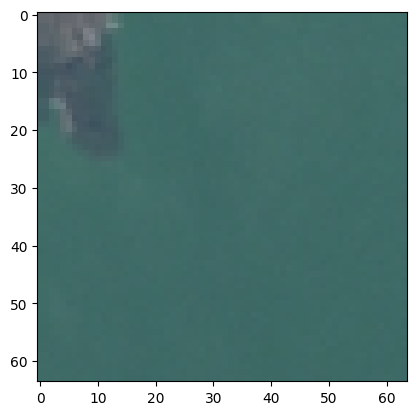

In [ ]:
print(f"Image Size: {image.shape[2]} x {image.shape[1]} x {image.shape[0]}")
print(f"Label: {label}")
print([key  for key, value in data.classes_names.items() if value == label][0])
plt.imshow(image.permute(1,2,0).cpu().numpy())
plt.show()

In [ ]:
train_dataset = MyDataset("EuroSat/dataset_rgb/train", transform_status=True)
test_dataset = MyDataset("EuroSat/dataset_rgb/test", transform_status=True)
train_dataset_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, drop_last=True)
test_dataset_loader = DataLoader(test_dataset, batch_size=32, shuffle=True, drop_last=True)

#### 3. Build the Model

In [ ]:
def build_model():
    vgg19 = models.vgg19(pretrained=True)
    for param in vgg19.parameters():
        param.requires_grad = False
    vgg19.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))
    vgg19.classifier = nn.Sequential(   nn.Flatten(),
                                        nn.Linear(512, 128),
                                        nn.ReLU(),
                                        nn.Dropout(0.2),
                                        nn.Linear(128, 10))
    loss_function = nn.CrossEntropyLoss()
    optimizer = optim.Adam(vgg19.parameters(), lr=1e-3)

    return vgg19.to(device), loss_function, optimizer

In [ ]:
model , loss_function, optimizer = build_model()

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:03<00:00, 144MB/s]


In [ ]:
summary(model, (3, 64, 64))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           1,792
              ReLU-2           [-1, 64, 64, 64]               0
            Conv2d-3           [-1, 64, 64, 64]          36,928
              ReLU-4           [-1, 64, 64, 64]               0
         MaxPool2d-5           [-1, 64, 32, 32]               0
            Conv2d-6          [-1, 128, 32, 32]          73,856
              ReLU-7          [-1, 128, 32, 32]               0
            Conv2d-8          [-1, 128, 32, 32]         147,584
              ReLU-9          [-1, 128, 32, 32]               0
        MaxPool2d-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 256, 16, 16]         295,168
             ReLU-12          [-1, 256, 16, 16]               0
           Conv2d-13          [-1, 256, 16, 16]         590,080
             ReLU-14          [-1, 256,

#### 4. Build the Train and Accuracy Functions

In [ ]:
def train_batch(model, loss_function, optimizer, image, label):
    model.train()
    optimizer.zero_grad()
    prediction = model(image)
    loss = loss_function(prediction, label.long().squeeze())
    loss.backward()
    optimizer.step()
    return loss.item()

In [ ]:
@torch.no_grad()
def accuracy(model, loss_function, image, label):
    model.eval()
    prediction = model(image)
    max_values, argmaxes = prediction.max(-1)
    is_correct = argmaxes == label.long().squeeze()
    return is_correct.cpu().numpy().tolist()

In [ ]:
@torch.no_grad()
def validation_loss(model, loss_function, image, label):
    model.eval()
    prediction = model(image)
    loss = loss_function(prediction, label.long().squeeze())
    return loss.item()

#### 5. Train the Model

In [ ]:
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []
for epoch in range(25):
    print(f"Epoch: {epoch+1}")
    train_epoch_losses = []
    train_epoch_accuracies = []
    for image, label in iter(train_dataset_loader):
        loss = train_batch(model, loss_function, optimizer, image, label)
        train_epoch_losses.append(loss)
    train_epoch_loss = np.mean(train_epoch_losses)
    print(f"Train Loss: {train_epoch_loss:.4f}")
    train_losses.append(train_epoch_loss)

    for image, label in iter(train_dataset_loader):
        is_correct = accuracy(model, loss_function, image, label)
        train_epoch_accuracies.extend(is_correct)
    train_epoch_accuracy = np.mean(train_epoch_accuracies)
    print(f"Train Accuracy: {train_epoch_accuracy*100:.2f}%")
    train_accuracies.append(train_epoch_accuracy)

    test_epoch_losses = []
    test_epoch_accuracies = []
    for image, label in iter(test_dataset_loader):
        loss = validation_loss(model, loss_function, image, label)
        test_epoch_losses.append(loss)
        is_correct = accuracy(model, loss_function, image, label)
        test_epoch_accuracies.extend(is_correct)
    test_epoch_loss = np.mean(test_epoch_losses)
    print(f"Test Loss: {test_epoch_loss:.4f}")
    test_losses.append(test_epoch_loss)
    test_epcoh_accuracy = np.mean(test_epoch_accuracies)
    print(f"Test Accuracy: {test_epcoh_accuracy*100:.2f}%")
    test_accuracies.append(test_epcoh_accuracy)


Epoch: 1
Train Loss: 0.4540
Train Accuracy: 90.68%
Test Loss: 0.3447
Test Accuracy: 87.90%
Epoch: 2
Train Loss: 0.2871
Train Accuracy: 92.04%
Test Loss: 0.3359
Test Accuracy: 88.62%
Epoch: 3
Train Loss: 0.2482
Train Accuracy: 93.13%
Test Loss: 0.3258
Test Accuracy: 89.02%
Epoch: 4
Train Loss: 0.2220
Train Accuracy: 94.12%
Test Loss: 0.3177
Test Accuracy: 89.34%
Epoch: 5
Train Loss: 0.2025
Train Accuracy: 94.59%
Test Loss: 0.3245
Test Accuracy: 89.48%
Epoch: 6
Train Loss: 0.1870
Train Accuracy: 94.96%
Test Loss: 0.3244
Test Accuracy: 89.48%
Epoch: 7
Train Loss: 0.1715
Train Accuracy: 95.70%
Test Loss: 0.3242
Test Accuracy: 90.10%
Epoch: 8
Train Loss: 0.1543
Train Accuracy: 96.17%
Test Loss: 0.3233
Test Accuracy: 89.60%
Epoch: 9
Train Loss: 0.1411
Train Accuracy: 97.01%
Test Loss: 0.3251
Test Accuracy: 89.86%
Epoch: 10
Train Loss: 0.1276
Train Accuracy: 97.18%
Test Loss: 0.3322
Test Accuracy: 90.40%
Epoch: 11
Train Loss: 0.1191
Train Accuracy: 97.21%
Test Loss: 0.3643
Test Accuracy: 89.5

In [ ]:
# Save the model
torch.save(model.state_dict(), 'trained_model.pth')

# Download the saved model file
from google.colab import files
files.download('trained_model.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#### 6. Visualize the Train Loss/Accuracy and the Test Loss/Accuracy

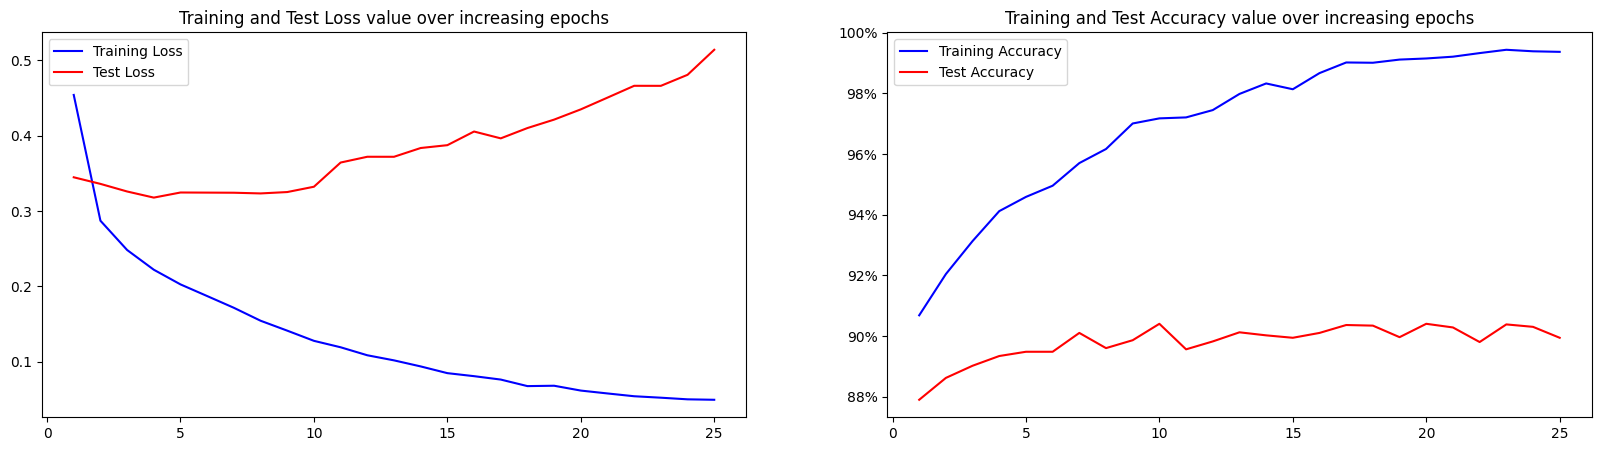

In [ ]:
epochs = np.arange(25)+1
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.title('Training and Test Loss value over increasing epochs')
plt.plot(epochs, train_losses,'b', label='Training Loss')
plt.plot(epochs, test_losses,'r', label='Test Loss')
plt.legend()
plt.subplot(122)
plt.title('Training and Test Accuracy value over increasing epochs')
plt.plot(epochs, train_accuracies,'b', label='Training Accuracy')
plt.plot(epochs, test_accuracies,'r', label='Test Accuracy')
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])
plt.legend()
plt.show()